<div>
    <img src="https://cdn.pixabay.com/photo/2018/02/08/11/17/network-3139214_1280.jpg"/>
</div>

<h1 id="trouble" style="color:#FFFFFF; background:#46ABAA; border:0.5px dotted;"> 
    <center>Trouble shooting
        <a class="anchor-link" href="#trouble" target="_self"></a>
    </center>
</h1>

- When running on OneDrive the logging (tensorboard) did not work. An error occured saying that the logdir is not a directory.

<h1 id="versions" style="color:#FFFFFF; background:#46ABAA; border:0.5px dotted;"> 
    <center>Versions
        <a class="anchor-link" href="#versions" target="_self"></a>
    </center>
</h1>

Python 3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]<br>
gym 0.21.0<br>
numpy 1.23.5<br>
pandas 1.5.3<br>
matplotlib 3.7.1<br>
stable_baselines3 1.7.0<br>
tensorflow 2.12.0<br>
keras 2.12.0<br>
openpyxl 3.1.2<br>

In [2]:
# Check your versions in case of problems.
import sys
import pkg_resources as pkg
print("Python", sys.version)
print("gym", pkg.get_distribution("gym").version)
print("numpy", pkg.get_distribution("numpy").version)
print("pandas", pkg.get_distribution("pandas").version)
print("matplotlib", pkg.get_distribution("matplotlib").version)
print("stable_baselines3", pkg.get_distribution("stable_baselines3").version)
print("tensorflow", pkg.get_distribution("tensorflow").version)
print("keras", pkg.get_distribution("keras").version)
print("openpyxl", pkg.get_distribution("openpyxl").version)

Python 3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]
gym 0.21.0
numpy 1.23.5
pandas 1.5.3
matplotlib 3.7.1
stable_baselines3 1.7.0
tensorflow 2.12.0
keras 2.12.0
openpyxl 3.1.2


In [3]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# from stable_baselines3 import SAC
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3 import A2C
# from stable_baselines3 import DDPG
# from stable_baselines3 import TD3

<h1 id="dataset" style="color:#FFFFFF; background:#46ABAA; border:0.5px dotted;"> 
    <center>Dataset
        <a class="anchor-link" href="#dataset" target="_self"></a>
    </center>
</h1>

# Load Data

**Important information:** 
- The first column contains the return of the asset. It will be used to calculate the value of the investment.
- All columns of the dataset are used to define the state.


In [5]:
# path = 'Datasets/0010_List_of_Repeating_Values.xlsx'
# path = 'Datasets/0030_Det_Return_Sine.xlsx'
path = 'Datasets/0040_Det_Overlap_Return_Sine.xlsx'

df = pd.read_excel(path)
df.head()

,Return
0,-0.013474
1,-0.011730
2,0.015147
3,0.023597
4,0.016397


# Split Data

In [6]:
Train_Ratio = 0.9
Train_Length = round(Train_Ratio * len(df))
Test_Length = len(df) - Train_Length
print('The length of the dataset is:', len(df))
print('The training set length is:', Train_Length)
print('The test set length is:', Test_Length)

The length of the dataset is: 250
The training set length is: 225
The test set length is: 25


In [7]:
df_train = df[0:Train_Length]
df_test = df[Train_Length:]

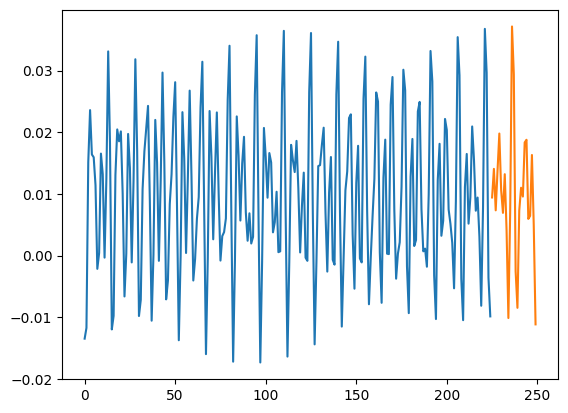

In [8]:
plt.plot(df_train.index, df_train.Return)
plt.plot(df_test.index, df_test.Return)

<h1 id="Descriptive" style="color:#FFFFFF; background:#46ABAA; border:0.5px dotted;"> 
    <center>Descriptive Analysis
        <a class="anchor-link" href="#Descriptive" target="_self">¶</a>
    </center>
</h1>

**Auto Correlation Plot**

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

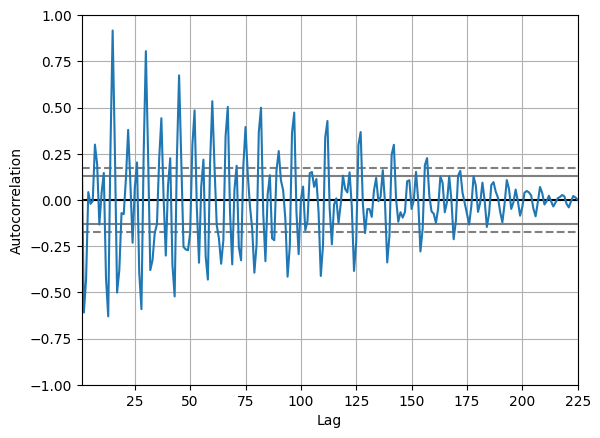

In [9]:
pd.plotting.autocorrelation_plot(df_train.Return)

The Autocorrelation plot for the data is:


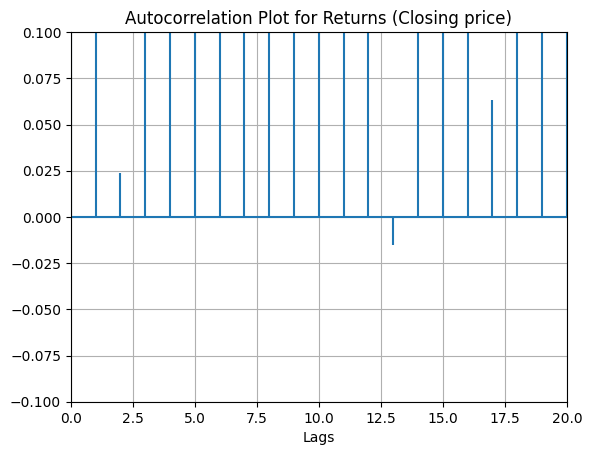

In [10]:
plt.title("Autocorrelation Plot for Returns (Closing price)")
 
# Providing x-axis name.
plt.xlabel("Lags")
 
# Plotting the Autocorrelation plot.
plt.acorr(df_train.Return, maxlags = 20)
 
# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
plt.xlim([0,20])
plt.ylim([-0.1,0.1])

plt.show()

<h1 id="add_func" style="color:#FFFFFF; background:#46ABAA; border:0.5px dotted;"> 
    <center>Additional Functions
        <a class="anchor-link" href="#add_func" target="_self"></a>
    </center>
</h1>

In [11]:
# This function is for running the model and collect rewards, actions, and total return.
# All the collected information is transferred to a dataframe.

def deploy(env, model):
    state = env.reset()
    done = False
    
    tot_reward = 0
    i = 0

    i_List = [i]            # List with iteration
    Action_List = []        # List of actions, first action will be taken below   
    Reward_List = [None]    # List with rewards, first entry is None
    Tot_Reward_List = [0]   # List with total reward, we start at Zero

    Done_List = [False]
    Stock_Return_List = [state[0]]
                            # List with observed stock return, first column in data
    Stock_Price_List = [1]  # List with normalized stock price, starts with price of 1
    State_List = [state]    # List with observed states
      
    Stock_Investment_List = [0]
    Bank_Account_List = [InitialBank]
    
    
    
    while not done:
    
        i = i + 1
        i_List.append(i)
    
        action, _state = model.predict(state, deterministic = True)
        state, reward, done, info = env.step(action)
    
        Action_List.append(action)
        Reward_List.append(reward)
        State_List.append(state)
        
        tot_reward = tot_reward + reward
        Tot_Reward_List.append(tot_reward)
        
        Done_List.append(done)
        Stock_Return_List.append(state[0])
        Stock_Price_List.append(Stock_Price_List[-1]*(1+state[0]))
        
        Stock_Investment_List.append(env.StockValue_Out)
        Bank_Account_List.append(env.BankValue_Out)

     
    Action_List.append(None)
   
   
    ####### BUY AND HOLD ###########
    # In the following we also add the buy-and-hold strategy to the results
    
    state = env.reset()
    done = False
    action = 1
    
    tot_reward = 0
    Tot_Reward_Buy_Hold_List = [0] 
    
    
    while not done:
        state, reward, done, info = env.step(action)
        tot_reward = tot_reward + reward
        Tot_Reward_Buy_Hold_List.append(tot_reward)
    
    
    
    Result_Dict = {'Time': i_List,
                   'Return': Stock_Return_List,
                   'Price': Stock_Price_List,
                   'State': State_List,
                   'Action': Action_List,
                   'Stock Investment': Stock_Investment_List,
                   'Bank Account': Bank_Account_List,
                   'Done': Done_List,
                   'Reward': Reward_List,
                   'Total Reward': Tot_Reward_List,
                   'Buy Hold Total Reward': Tot_Reward_Buy_Hold_List}  

    
    Result_df = pd.DataFrame(Result_Dict)
    

    return Result_df


In [12]:
from TradingPlots import Plot_Results

<h1 id="Environment" style="color:#FFFFFF; background:#46ABAA; border:0.5px dotted;"> 
    <center>Environment
        <a class="anchor-link" href="#Environment" target="_self"></a>
    </center>
</h1>

In [13]:
InitialBank = 10     # Initial wealth
Interest_Rate = 0.00  # Interest rate of bank account
transaction_cost_pct = 0.000

In [14]:
from TradingEnvironments import InOut

env_train = InOut(df_train, InitialBank, Interest_Rate, transaction_cost_pct)
env_test = InOut(df_test, InitialBank, Interest_Rate, transaction_cost_pct)

C:\Users\denis\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
C:\Users\denis\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


<h1 id="A2C_model" style="color:#FFFFFF; background:#AF944B; border:0.5px dotted;"> 
    <center>A2C - Model 
        <a class="anchor-link" href="#A2C_model" target="_self"></a>
    </center>
</h1>

In [15]:
def train_A2C(env_train,
              model_name,
              timesteps = 1000,
              logdir = None):
   
    model = A2C('MlpPolicy',
                env_train,
                gamma = 1,
                verbose = 1,
                tensorboard_log = logdir)
    
    start = time.time()
    
    model.learn(total_timesteps = timesteps)

    end = time.time()

    model.save(f"models/{model_name}")
    print(' - Training time (A2C): ', (end - start) / 60, ' minutes')
    return model

In [16]:
for i in range(1,6):
    model_a2c = train_A2C(env_train, 
                          model_name = "A2C_Discrete_{}".format(i),
                          logdir = 'logs',
                          timesteps = 1000)
        

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\A2C_16
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 224      |
|    ep_rew_mean        | 18       |
| time/                 |          |
|    fps                | 529      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.68    |
|    explained_variance | -3.18    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.0407   |
|    value_loss         | 0.00565  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 224      |
|    ep_rew_mean        | 36.4     |
| time/                 |          |
|    fps                | 505      |
|    iterations         | 200   

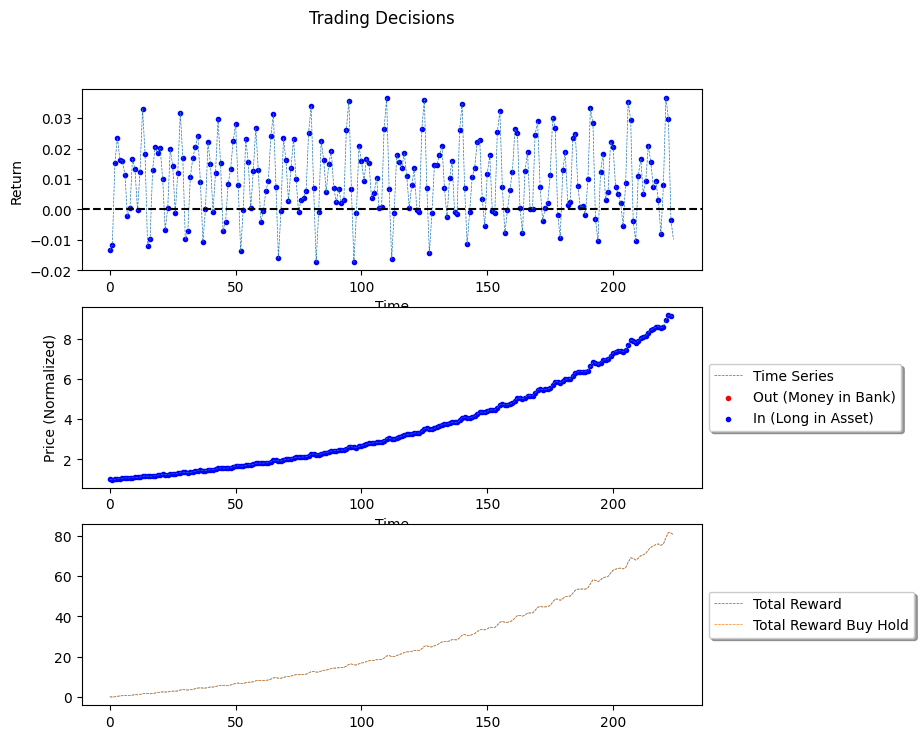

In [17]:
# Deploy the model on the training data
Train_Result_df = deploy(env_train, model_a2c)

# Plot the results
Plot_Results(Train_Result_df)

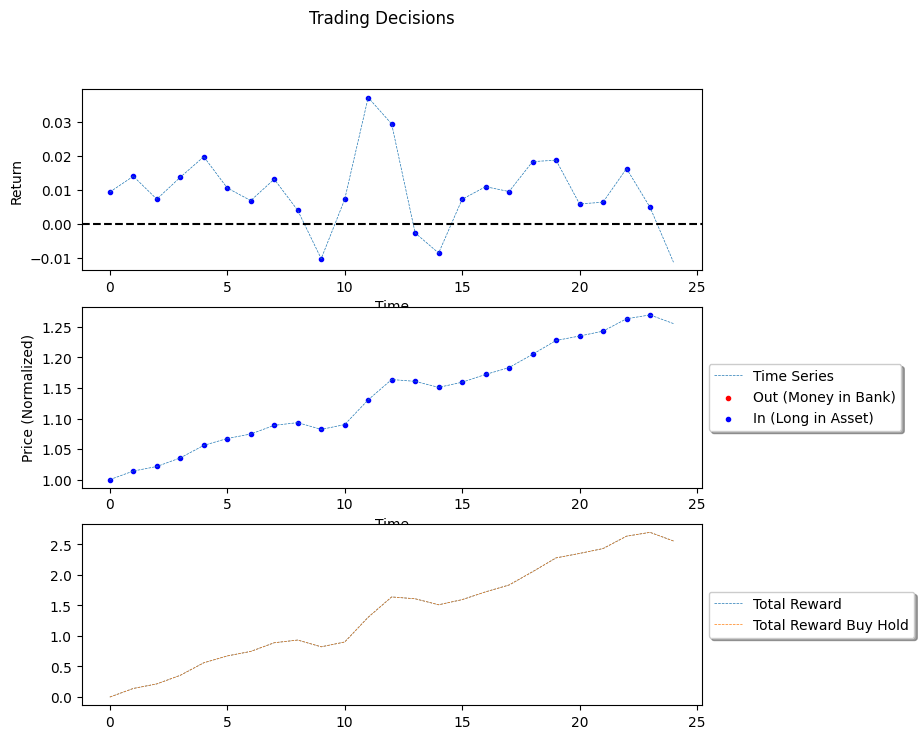

In [18]:
# Deploy the model on the test data
Test_Result_df = deploy(env_test, model_a2c)

# Plot the results
Plot_Results(Test_Result_df)

<h1 id="PPO_model" style="color:#FFFFFF; background:#9141B1; border:0.5px dotted;"> 
    <center>PPO - Model and Training
        <a class="anchor-link" href="#PPO_model" target="_self"></a>
    </center>
</h1>

In [19]:
def train_PPO(env_train,
              model_name,
              timesteps=1000,
              logdir = None):
    
    model = PPO('MlpPolicy',
                env_train, 
                gamma = 1,
                verbose = 1, tensorboard_log = logdir)
    
    start = time.time()    
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"models/{model_name}")
    print(' - Training time (PPO): ', (end - start) / 60, ' minutes')
    return model

In [20]:
for i in range(1,6):
    model_ppo = train_PPO(env_train, 
                          model_name = "PPO_Discrete_{}".format(i),
                          logdir = 'logs',
                          timesteps = 1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\PPO_6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 224      |
|    ep_rew_mean     | 21       |
| time/              |          |
|    fps             | 1258     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
 - Training time (PPO):  0.05915120045344035  minutes
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\PPO_7
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 224      |
|    ep_rew_mean     | 21.5     |
| time/              |          |
|    fps             | 1104     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
 - Training time (PPO):  0.0624284

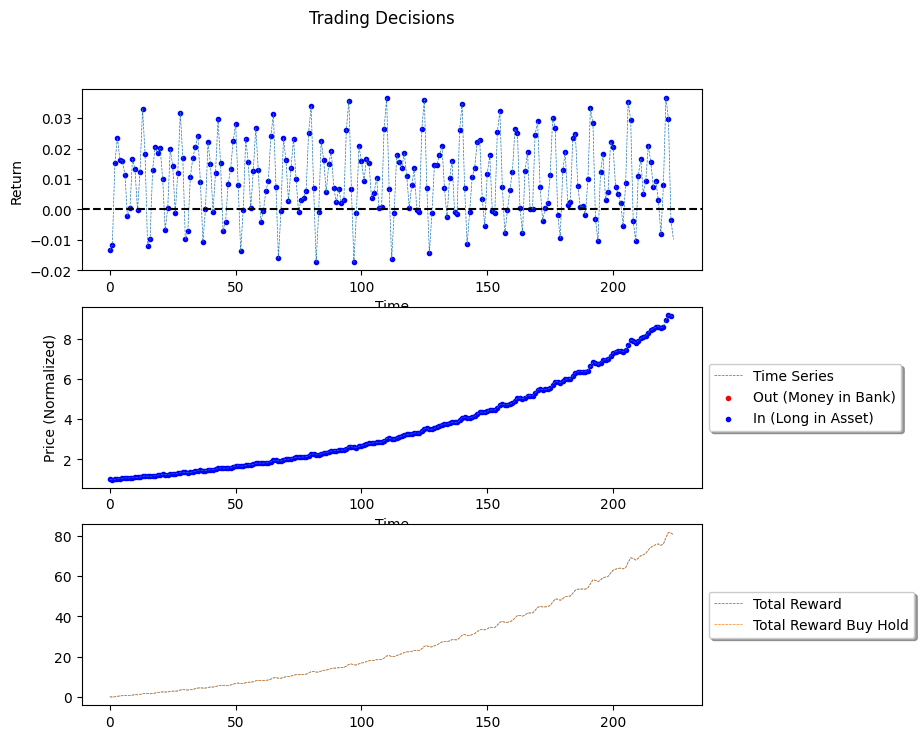

In [21]:
# Deploy the model on the training data
Train_Result_df = deploy(env_train, model_ppo)

# Plot the results
Plot_Results(Train_Result_df)

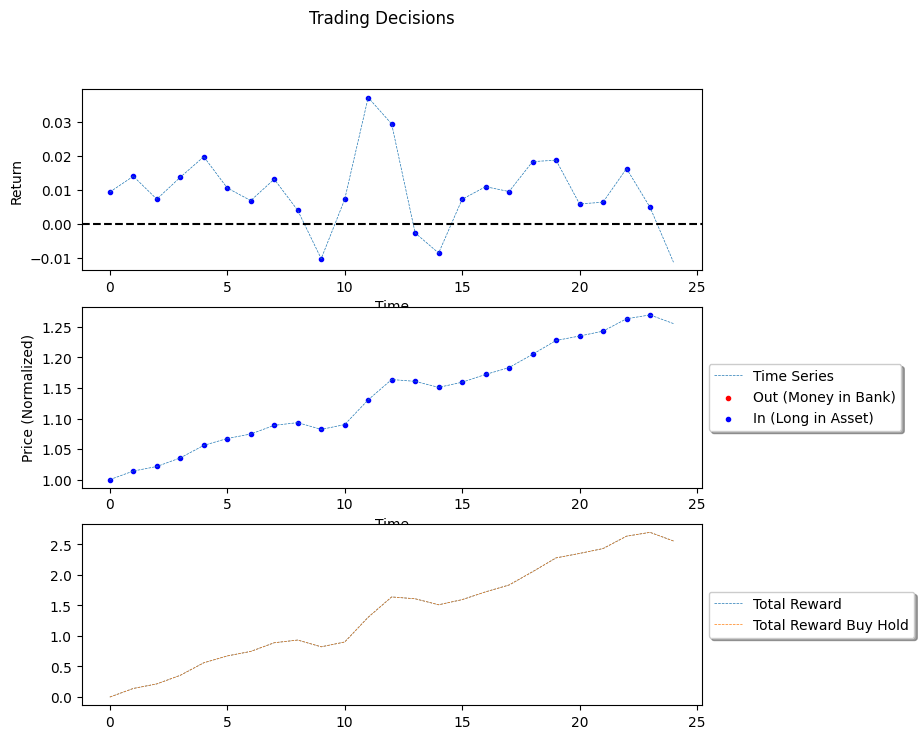

In [22]:
# Deploy the model on the test data
Test_Result_df = deploy(env_test, model_ppo)

# Plot the results
Plot_Results(Test_Result_df)

<h1 id="DQN_model" style="color:#FFFFFF; background:#5B9045; border:0.5px dotted;"> 
    <center>DQN
        <a class="anchor-link" href="#DQN_model" target="_self"></a>
    </center>
</h1>

In [23]:
def train_DQN(env_train,
              model_name,
              timesteps = 1000,
              logdir = None):

    model = DQN('MlpPolicy', 
                env_train,
                gamma = 1,
                verbose = 1,
                tensorboard_log = logdir)
    
    start = time.time()
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"models/{model_name}")
    print(' - Training time (DQN): ', (end - start) / 60, ' minutes')
    return model

In [24]:
for i in range(1,6):
    model_dqn = train_DQN(env_train, 
                          model_name = "DQN_Discrete_{}".format(i),
                          logdir = 'logs',
                          timesteps = 1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 224      |
|    ep_rew_mean      | 21.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 8041     |
|    time_elapsed     | 0        |
|    total_timesteps  | 896      |
----------------------------------
 - Training time (DQN):  0.0021821339925130207  minutes
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 224      |
|    ep_rew_mean      | 20       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10297    |
|    time_elapsed     | 0        |
|    total_t

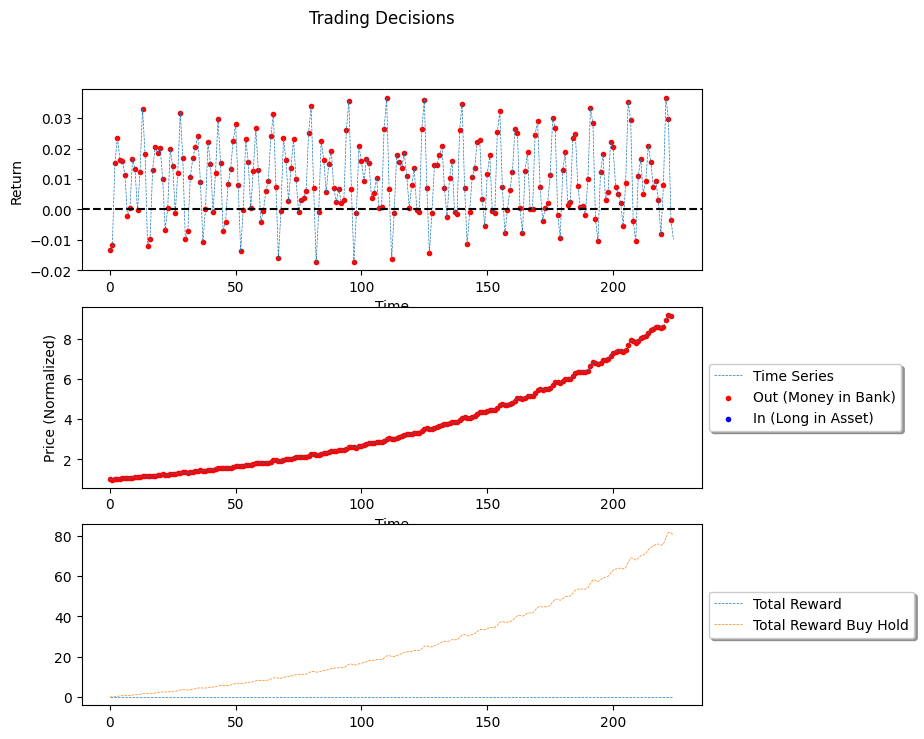

In [25]:
# Deploy the model on the training data
Train_Result_df = deploy(env_train, model_dqn)

# Plot the results
Plot_Results(Train_Result_df)

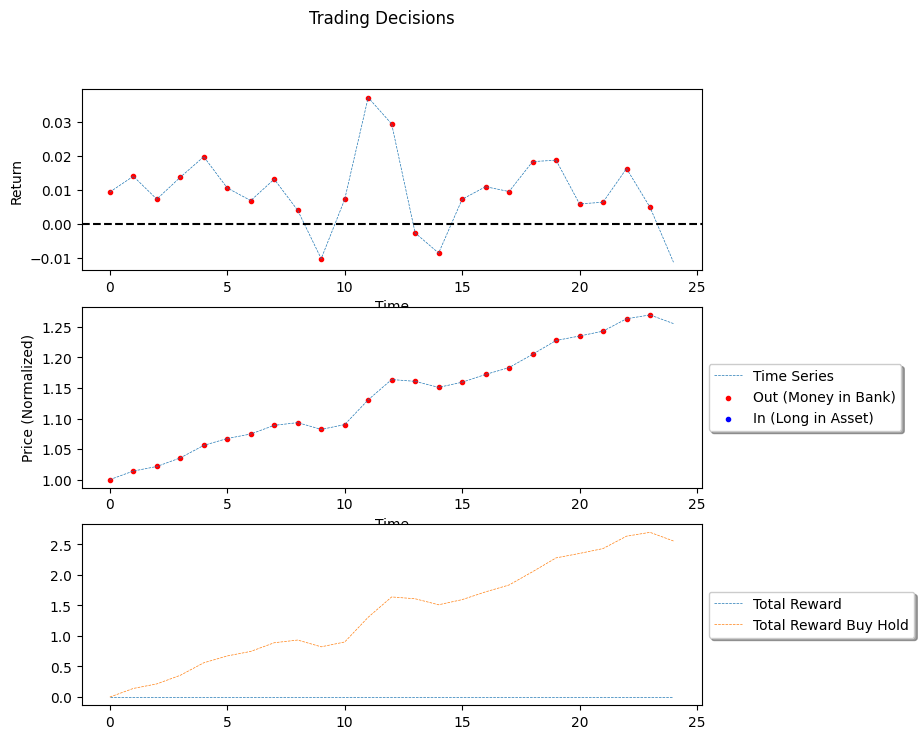

In [26]:
# Deploy the model on the test data
Test_Result_df = deploy(env_test, model_dqn)

# Plot the results
Plot_Results(Test_Result_df)

<h1 id="Deploy" style="color:#FFFFFF; background:#F0A31C; border:0.5px dotted;"> 
    <center>Load and deploy model
        <a class="anchor-link" href="#Deploy" target="_self"></a>
    </center>
</h1>

**Training Data**

In [27]:
# Here the desired model van be loaded
model_name="models/DQN_Discrete_2"

In [28]:
# Here the desired model van be loaded
model = DQN.load(model_name, env = env_train)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


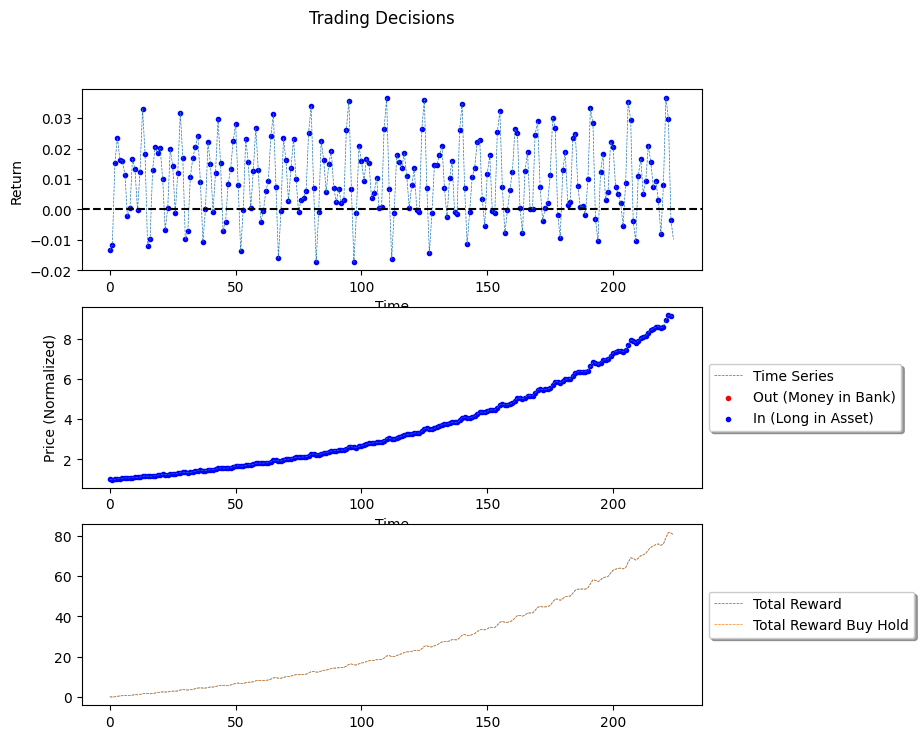

In [29]:
# Deploy the model on the training data
Train_Result_df = deploy(env_train, model)

# Plot the results
Plot_Results(Train_Result_df)

**Test Data**

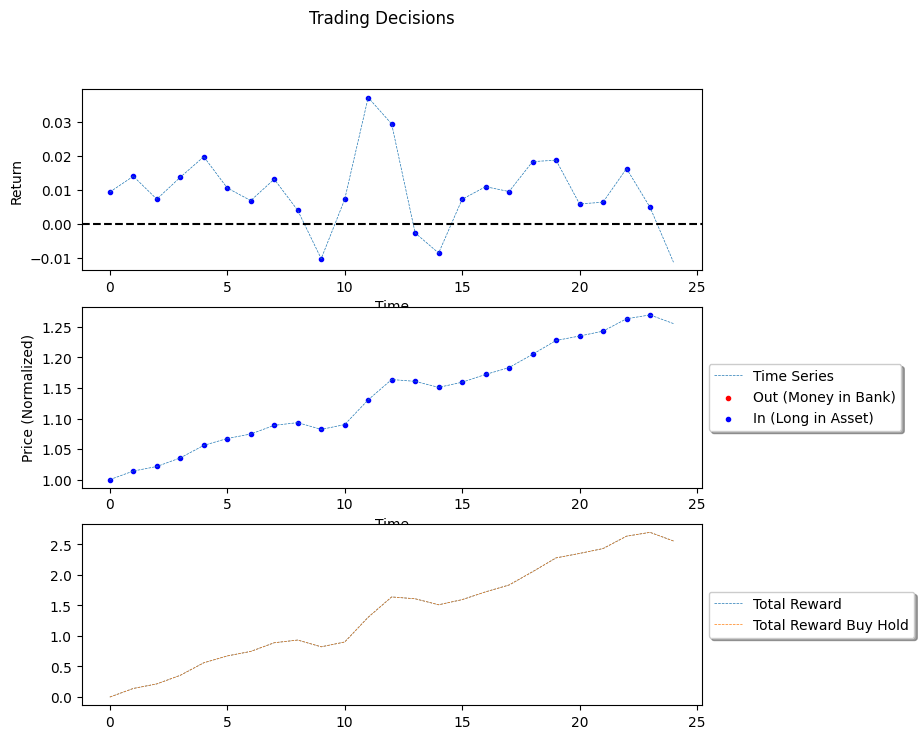

In [30]:
# Deploy the model on the training data
Test_Result_df = deploy(env_test, model)

# Plot the results
Plot_Results(Test_Result_df)

<h1 id="Optimal" style="color:#000000; background:#DAF7A6; border:0.5px dotted;"> 
    <center>Deploy with Optimal Actions
        <a class="anchor-link" href="#Optimal" target="_self"></a>
    </center>
</h1>

A text file with optimal actions needs to be available.

In [13]:
# This function is for running the model and collect rewards, actions, and total return.
# All the collected information is transferred to a dataframe.

def deploy_optimal(env, Optimal_Action_List):
    state = env.reset()
    done = False
    
    tot_reward = 0
    i = 0

    i_List = [i]            # List with iteration
    Action_List = []        # List of actions, first action will be taken below   
    Reward_List = [None]    # List with rewards, first entry is None
    Tot_Reward_List = [0]   # List with total reward, we start at Zero

    Done_List = [False]
    Stock_Return_List = [state[0]]
                            # List with observed stock return, first column in data
    Stock_Price_List = [1]  # List with normalized stock price, starts with price of 1
    State_List = [state]    # List with observed states
      
    Stock_Investment_List = [0]
    Bank_Account_List = [InitialBank]
    
    
    
    while not done:
    
        i = i + 1
        i_List.append(i)
    
        action = Optimal_Action_List[i-1]
        state, reward, done, info = env.step(action)
    
        Action_List.append(action)
        Reward_List.append(reward)
        State_List.append(state)
        
        tot_reward = tot_reward + reward
        Tot_Reward_List.append(tot_reward)
        
        Done_List.append(done)
        Stock_Return_List.append(state[0])
        Stock_Price_List.append(Stock_Price_List[-1]*(1+state[0]))
        
        Stock_Investment_List.append(env.StockValue_Out)
        Bank_Account_List.append(env.BankValue_Out)

     
    Action_List.append(None)
   
   
    ####### BUY AND HOLD ###########
    # In the following we also add the buy-and-hold strategy to the results
    
    state = env.reset()
    done = False
    action = 1
    
    tot_reward = 0
    Tot_Reward_Buy_Hold_List = [0] 
    
    
    while not done:
        state, reward, done, info = env.step(action)
        tot_reward = tot_reward + reward
        Tot_Reward_Buy_Hold_List.append(tot_reward)
    
    
    
    Result_Dict = {'Time': i_List,
                   'Return': Stock_Return_List,
                   'Price': Stock_Price_List,
                   'State': State_List,
                   'Action': Action_List,
                   'Stock Investment': Stock_Investment_List,
                   'Bank Account': Bank_Account_List,
                   'Done': Done_List,
                   'Reward': Reward_List,
                   'Total Reward': Tot_Reward_List,
                   'Buy Hold Total Reward': Tot_Reward_Buy_Hold_List}  

    
    Result_df = pd.DataFrame(Result_Dict)
    

    return Result_df

In [31]:
Optimal_Action_List = []

# Open file and read the content in a list
with open('Datasets/0030_Optimal_Actions.txt', 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        action = int(line[:-1])

        # add current item to the list
        Optimal_Action_List.append(action)

# Display list
print(Optimal_Action_List)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


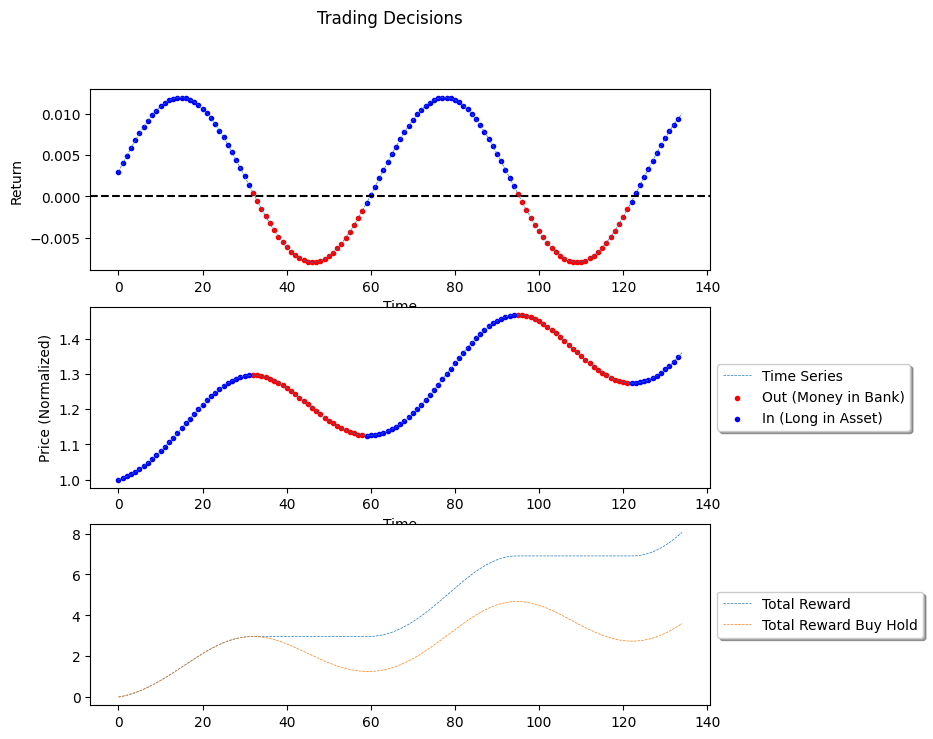

In [33]:
# Deploy the model on the training data
Optimal_Result_df = deploy_optimal(env_train, Optimal_Action_List)

# Plot the results
Plot_Results(Optimal_Result_df)

In [34]:
Optimal_Result_df.tail()

,Time,Return,Price,State,Action,Stock Investment,Bank Account,Done,Reward,Total Reward,Buy Hold Total Reward,In_Return,Out_Return,In_Price,Out_Price
130,130,0.007087,1.312570,[0.0070866146],1.0,17.424939,0.0,False,0.122615,7.424939,3.125700,0.007087,None,1.31257,None
131,131,0.007921,1.322966,[0.0079207355],1.0,17.562957,0.0,False,0.138018,7.562957,3.229665,0.007921,None,1.322966,None
132,132,0.008696,1.334471,[0.008695697],1.0,17.715679,0.0,False,0.152722,7.715679,3.344706,0.008696,None,1.334471,None
133,133,0.009404,1.347020,[0.009403759],1.0,17.882273,0.0,False,0.166594,7.882273,3.470196,0.009404,None,1.34702,None
134,134,0.010038,1.360541,[0.010037844],NaN,18.061773,0.0,True,0.179499,8.061773,3.605408,None,None,None,None


In [22]:
env_train.reset()

array([0.00299833], dtype=float32)